In [19]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
from skimage.feature import graycomatrix, graycoprops
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.impute import SimpleImputer
import joblib

In [20]:
def calculate_eccentricity(contour):
    if len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        major_axis = max(ellipse[1])
        minor_axis = min(ellipse[1])
        eccentricity = np.sqrt(1 - (minor_axis ** 2 / major_axis ** 2))
        return eccentricity
    else:
        return None

In [21]:
def calculate_metric(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter > 0:
        metric = (4 * np.pi * area) / (perimeter ** 2)
        return metric
    else:
        return None


In [22]:
def extract(image_path):
    """Ekstraksi fitur dari gambar"""
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Tidak bisa membaca gambar: {image_path}")
        
        resized_image = cv2.resize(image, (300, 300))
        
        # Crop image
        height, width = resized_image.shape[:2]
        start_x, start_y = width // 4, height // 4
        end_x, end_y = start_x + (width // 2), start_y + (height // 2)
        cropped_image = resized_image[start_y:end_y, start_x:end_x]
        
        # Convert ke grayscale
        cropped_gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        
        # Fitur Warna
        # Convert to different color spaces
        gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2LAB)
        
        features = []
        
        # 1. Color Features
        # BGR features
        for channel in range(3):
            features.extend([
                np.mean(cropped_image[:, :, channel]),
                np.std(cropped_image[:, :, channel]),
                np.percentile(cropped_image[:, :, channel], 25),
                np.percentile(cropped_image[:, :, channel], 75)
            ])
        
        # HSV features
        for channel in range(3):
            features.extend([
                np.mean(hsv[:, :, channel]),
                np.std(hsv[:, :, channel])
            ])
        
        # LAB features
        for channel in range(3):
            features.extend([
                np.mean(lab[:, :, channel]),
                np.std(lab[:, :, channel])
            ])
        
        # Fitur Tekstur (GLCM)
        glcm = graycomatrix(cropped_gray, distances=[1], angles=[0], 
                           levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        
        # Fitur Bentuk
        _, otsu_threshold = cv2.threshold(cropped_gray, 0, 255, 
                                        cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(otsu_threshold, cv2.RETR_EXTERNAL, 
                                     cv2.CHAIN_APPROX_SIMPLE)
        
        # Analisis eccentricity dan metric
        eccentricities = []
        metrics = []
        
        for contour in contours:
            ecc = calculate_eccentricity(contour)
            metric = calculate_metric(contour)
            
            if ecc is not None:
                eccentricities.append(ecc)
            if metric is not None:
                metrics.append(metric)
        
        avg_eccentricity = np.mean(eccentricities) if eccentricities else 0
        avg_metric = np.mean(metrics) if metrics else 0
        
        # Gabungkan semua fitur
        features.extend([
            contrast, correlation, energy, homogeneity,
            avg_eccentricity, avg_metric
        ])
        
        return features
    
    except Exception as e:
        print(f"Error dalam ekstraksi fitur: {str(e)}")
        return None

In [23]:
def load_dataset(base_path):
    """Load dataset dari folder"""
    features = []
    labels = []
    processed_count = 0
    error_count = 0

    for class_name in os.listdir(base_path):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            print(f"Memproses kelas: {class_name}")
            for image_name in os.listdir(class_path):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_path, image_name)
                    try:
                        image_features = extract(image_path)
                        if image_features is not None:
                            features.append(image_features)
                            labels.append(class_name)
                            processed_count += 1
                            if processed_count % 10 == 0:
                                print(f"Berhasil memproses {processed_count} gambar")
                    except Exception as e:
                        print(f"Error memproses {image_path}: {str(e)}")

    print(f"Total errors encountered: {error_count}")
    return np.array(features), np.array(labels)


In [24]:
def analyze_distances(X_train, X_test, y_train, y_test):
    """Analisis performa berbagai metrik jarak"""
    metrics = ['manhattan', 'euclidean', 'minkowski']
    n_neighbors_range = [3, 5, 7, 9]
    
    results = {}
    best_score = -1
    best_config = None
    
    plt.figure(figsize=(15, 10))
    
    for metric in metrics:
        results[metric] = {'silhouette': [], 'accuracy': []}
        
        for n in n_neighbors_range:
            print(f"\nAnalisis untuk {metric} distance dengan k={n}")
            
            if metric == 'minkowski':
                knn = KNeighborsClassifier(n_neighbors=n, metric=metric, p=3)
            else:
                knn = KNeighborsClassifier(n_neighbors=n, metric=metric)
            
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            
            silhouette_avg = silhouette_score(X_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"Silhouette Score: {silhouette_avg:.4f}")
            print(f"Accuracy: {accuracy:.4f}")
            
            results[metric]['silhouette'].append(silhouette_avg)
            results[metric]['accuracy'].append(accuracy)
            
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_config = {
                    'metric': metric,
                    'n_neighbors': n,
                    'silhouette': silhouette_avg,
                    'accuracy': accuracy
                }
    
    # Plot hasil
    plt.subplot(2, 1, 1)
    for metric in metrics:
        plt.plot(n_neighbors_range, results[metric]['silhouette'], 
                marker='o', label=f'{metric}')
    plt.title('Perbandingan Silhouette Score')
    plt.xlabel('Jumlah Neighbors (k)')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    for metric in metrics:
        plt.plot(n_neighbors_range, results[metric]['accuracy'], 
                marker='o', label=f'{metric}')
    plt.title('Perbandingan Accuracy')
    plt.xlabel('Jumlah Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nKonfigurasi Terbaik:")
    print(f"Metrik Jarak: {best_config['metric']}")
    print(f"Jumlah Neighbors: {best_config['n_neighbors']}")
    print(f"Silhouette Score: {best_config['silhouette']:.4f}")
    print(f"Accuracy: {best_config['accuracy']:.4f}")
    
    return best_config



In [25]:
def train_and_evaluate_model():
    """Training dan evaluasi model"""
    dataset_path = r"D:\! Code\Klasifikasi\dataset\Local"
    
    print("Loading dataset...")

    features, labels = load_dataset(dataset_path)
    
    if len(features) == 0:
        print("Dataset kosong")
        return None, None, None, 0
    
    print(f"\nTotal data: {len(features)} samples")
    print(f"Jumlah fitur: {features.shape[1]}")
    print(f"Kelas unik: {set(labels)}")
    
    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    # Handling missing values
    imputer = SimpleImputer(strategy='median')
    features = imputer.fit_transform(features)
    
    # Normalisasi
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        features_scaled, labels_encoded, test_size=0.1, random_state=42, stratify=labels_encoded
    )
    
    print("\nMenganalisis performa metrik jarak...")
    best_config = analyze_distances(X_train, X_test, y_train, y_test)
    
    # Train model final dengan konfigurasi terbaik
    if best_config['metric'] == 'minkowski':
        final_model = KNeighborsClassifier(
            n_neighbors=best_config['n_neighbors'],
            metric=best_config['metric'],
            p=3
        )
    else:
        final_model = KNeighborsClassifier(
            n_neighbors=best_config['n_neighbors'],
            metric=best_config['metric']
        )
    
    final_model.fit(X_train, y_train)
    
    # Evaluasi model
    y_pred = final_model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Simpan model
    joblib.dump(final_model, 'model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(label_encoder, 'label_encoder.pkl')
    
    return final_model, scaler, label_encoder, best_config['accuracy']


In [26]:
def predict_single_image(model, scaler, label_encoder, image_path):
    """Prediksi kelas untuk satu gambar"""
    try:
        features = extract(image_path)
        if features is None:
            raise ValueError("Gagal mengekstrak fitur")
        
        features = np.array(features).reshape(1, -1)
        features_scaled = scaler.transform(features)
        prediction = model.predict(features_scaled)
        return label_encoder.inverse_transform(prediction)[0]
    
    except Exception as e:
        print(f"Error dalam prediksi: {str(e)}")
        return None

Starting training process...
Loading dataset...
Memproses kelas: Anggrek_Bulan(L)
Berhasil memproses 10 gambar
Berhasil memproses 20 gambar
Berhasil memproses 30 gambar
Berhasil memproses 40 gambar
Berhasil memproses 50 gambar
Berhasil memproses 60 gambar
Berhasil memproses 70 gambar
Berhasil memproses 80 gambar
Berhasil memproses 90 gambar
Berhasil memproses 100 gambar
Memproses kelas: Anggrek_Cattelya(L)
Berhasil memproses 110 gambar
Berhasil memproses 120 gambar
Berhasil memproses 130 gambar
Berhasil memproses 140 gambar
Berhasil memproses 150 gambar
Berhasil memproses 160 gambar
Berhasil memproses 170 gambar
Berhasil memproses 180 gambar
Berhasil memproses 190 gambar
Berhasil memproses 200 gambar
Memproses kelas: Anggrek_Dendrobium(L)
Berhasil memproses 210 gambar
Berhasil memproses 220 gambar
Berhasil memproses 230 gambar
Berhasil memproses 240 gambar
Berhasil memproses 250 gambar
Berhasil memproses 260 gambar
Berhasil memproses 270 gambar
Berhasil memproses 280 gambar
Berhasil me

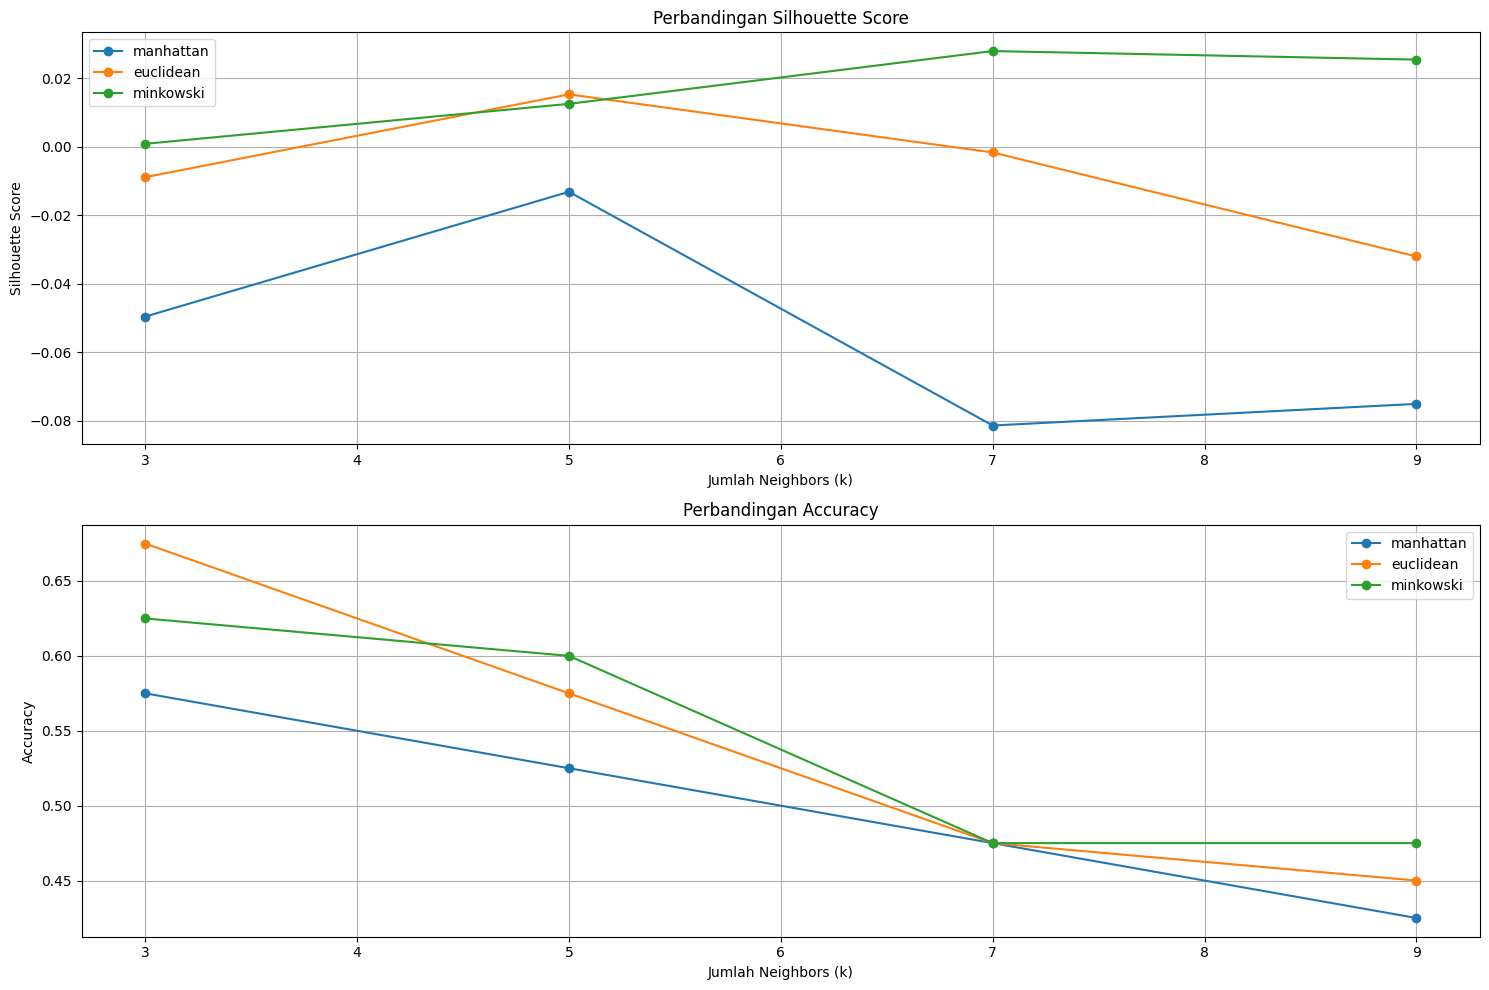


Konfigurasi Terbaik:
Metrik Jarak: minkowski
Jumlah Neighbors: 7
Silhouette Score: 0.0279
Accuracy: 0.4750

Classification Report:
                       precision    recall  f1-score   support

     Anggrek_Bulan(L)       0.43      1.00      0.61        10
  Anggrek_Cattelya(L)       0.60      0.30      0.40        10
Anggrek_Dendrobium(L)       0.44      0.40      0.42        10
     Bukan_Anggrek(L)       0.67      0.20      0.31        10

             accuracy                           0.47        40
            macro avg       0.54      0.48      0.43        40
         weighted avg       0.54      0.47      0.43        40



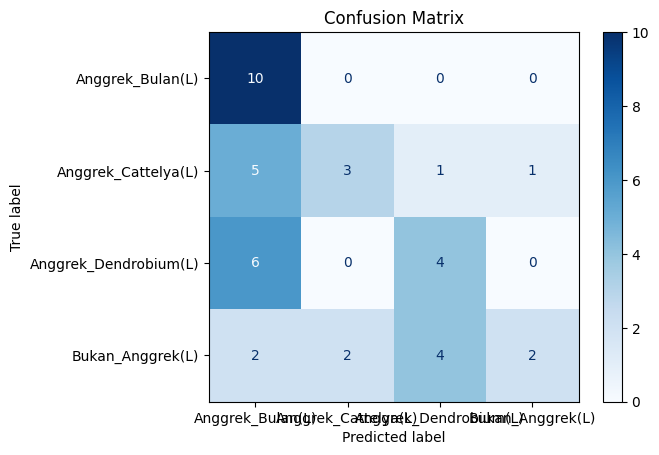


Model siap untuk prediksi!
Accuracy model: 0.4750


In [ ]:
if __name__ == "__main__":
    print("Starting training process...")
    model, scaler, label_encoder, accuracy = train_and_evaluate_model()
    
    if model is None:
        print("Training gagal. Program berhenti.")
        exit()
    
    print("\nModel siap untuk prediksi!")
    print(f"Accuracy model: {accuracy:.4f}")
    
    while True:
        root = Tk()
        root.withdraw()
        image_path = filedialog.askopenfilename(
            filetypes=[("Image Files", ".jpg;.png;*.jpeg")]
        )
        
        if not image_path:
            print("Tidak ada file yang dipilih. Program berhenti.")
            break
        
        prediction = predict_single_image(model, scaler, label_encoder, image_path)
        if prediction is not None:
            print(f"\nHasil Prediksi: {prediction}")
        
        lanjut = input("\nIngin memprediksi gambar lain? (y/n): ").lower()
        if lanjut != 'y':
            print("Program selesai.")
            break